# Fake news detection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [3]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [4]:
fake.shape

(23481, 4)

In [5]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [6]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [7]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [8]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [9]:
# Check the data
data.head()

,title,text,subject,date,target
0,Obama says Congress must end deadlock on Zika ...,WASHINGTON (Reuters) - U.S. President Barack O...,politicsNews,"July 1, 2016",true
1,Longtime Republican Strategist Just Cast Her ...,"This is not something that happens every day, ...",News,"November 7, 2016",fake
2,Factbox: Why the Zika virus is causing alarm,Global health officials are racing to better u...,politicsNews,"June 23, 2016",true
3,Betsy DeVos Gets SKEWERED After Dept. Of Educ...,Donald Trump s Education Department is patheti...,News,"February 12, 2017",fake
4,"Republicans unveil tax cut bill, but the hard ...",WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"November 2, 2017",true


In [10]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Obama says Congress must end deadlock on Zika ...,WASHINGTON (Reuters) - U.S. President Barack O...,politicsNews,true
1,Longtime Republican Strategist Just Cast Her ...,"This is not something that happens every day, ...",News,fake
2,Factbox: Why the Zika virus is causing alarm,Global health officials are racing to better u...,politicsNews,true
3,Betsy DeVos Gets SKEWERED After Dept. Of Educ...,Donald Trump s Education Department is patheti...,News,fake
4,"Republicans unveil tax cut bill, but the hard ...",WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,true


In [11]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,WASHINGTON (Reuters) - U.S. President Barack O...,politicsNews,true
1,"This is not something that happens every day, ...",News,fake
2,Global health officials are racing to better u...,politicsNews,true
3,Donald Trump s Education Department is patheti...,News,fake
4,WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,true


In [12]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,washington (reuters) - u.s. president barack o...,politicsNews,true
1,"this is not something that happens every day, ...",News,fake
2,global health officials are racing to better u...,politicsNews,true
3,donald trump s education department is patheti...,News,fake
4,washington (reuters) - u.s. house of represent...,politicsNews,true


In [13]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [14]:
# Check
data.head()

,text,subject,target
0,washington reuters us president barack obama ...,politicsNews,true
1,this is not something that happens every day b...,News,fake
2,global health officials are racing to better u...,politicsNews,true
3,donald trump s education department is patheti...,News,fake
4,washington reuters us house of representative...,politicsNews,true


In [15]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to C:\Users\Gaurav
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
data.head()

,text,subject,target
0,washington reuters us president barack obama f...,politicsNews,true
1,something happens every day exactly ana navarr...,News,fake
2,global health officials racing better understa...,politicsNews,true
3,donald trump education department pathetic bet...,News,fake
4,washington reuters us house representatives re...,politicsNews,true


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


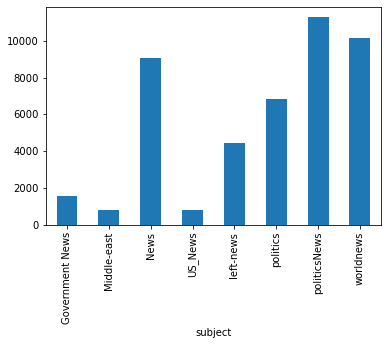

In [17]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


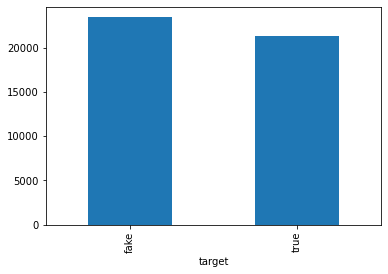

In [18]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

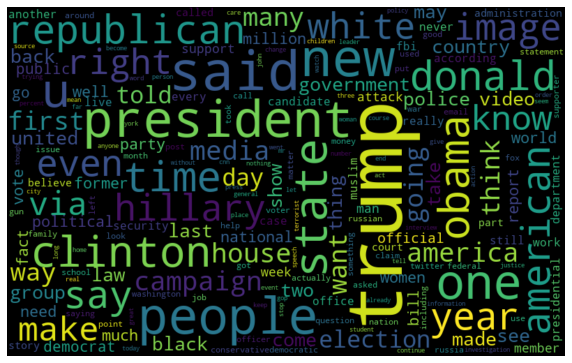

In [19]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

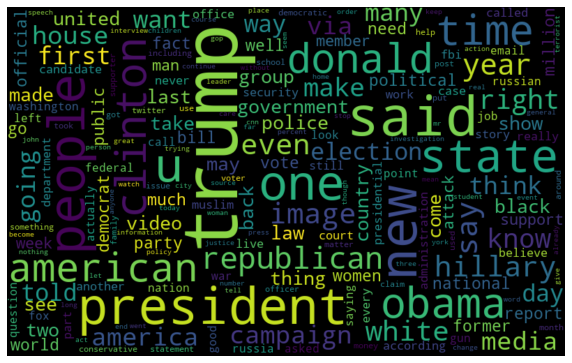

In [20]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

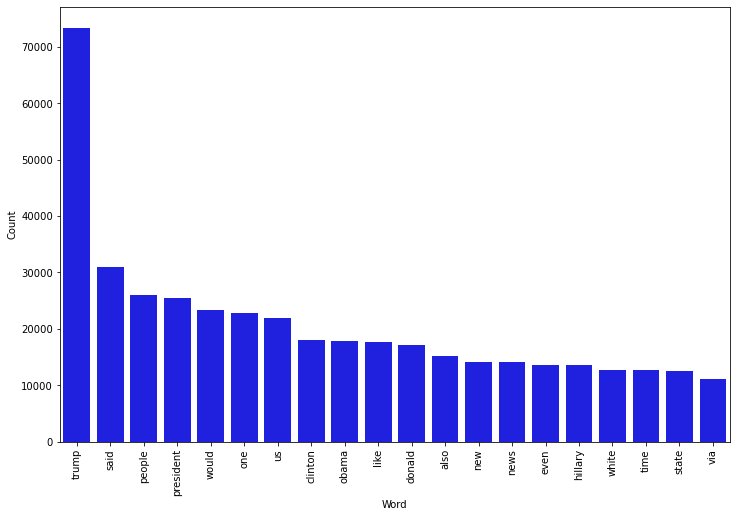

In [22]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

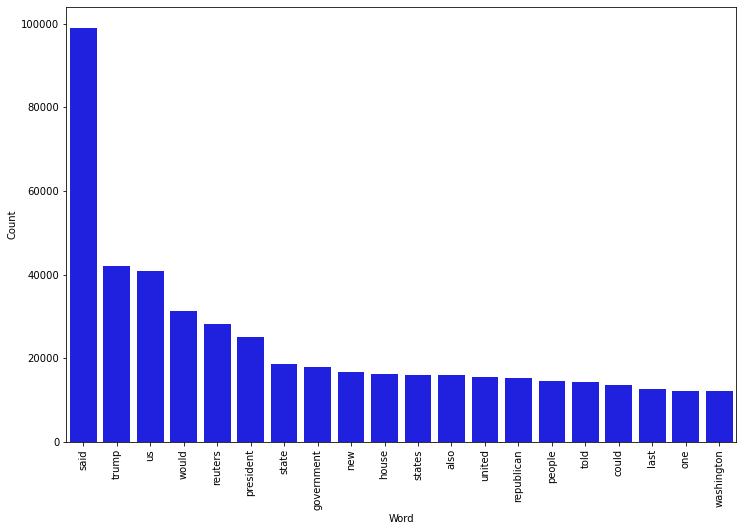

In [23]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [24]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [25]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Logistic regression

In [26]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.71%


Confusion matrix, without normalization


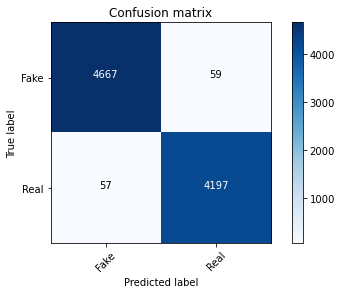

In [27]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])